In [1]:
import os
import cpuinfo
import numpy as np
import tensorflow as tf
import imageio
from tqdm import tqdm
import multiprocessing as mp
cores_count = mp.cpu_count()
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
cpuinfo.get_cpu_info()['brand'], tf.test.is_gpu_available()

('Intel(R) Core(TM) i5-7500 CPU @ 3.40GHz', False)

In [3]:
from utils.unet import get_compiled_model
from utils.generate_train_set import get_next_batch
# from utils.card_generator import get_card_with_face_pool
from utils import configs

Using TensorFlow backend.


In [4]:
train_num = 20
model_weights_path = './data/weights/n{}/w_000.h5'.format(configs.START_NEURONS)

In [5]:
train_x = None  # np.zeros((train_num, h_size, w_size, 3), dtype='float32')
train_y = None  # np.zeros((train_num, h_size, w_size, 1), dtype='float32')

# Construct model

In [6]:
model = get_compiled_model();

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
only_gi_bg = False
if os.path.isfile(model_weights_path):
    only_gi_bg = True
    model.load_weights(model_weights_path)

# Generate train set
- get_gi_bg (60%)
- generate_rand_bg (30%)
- get_flat_simple_bg (5%)
- get_simple_bg (5%)

In [8]:
# card_with_face_pool = get_card_with_face_pool()

In [9]:
%%time
generate_batch_size = train_num // cores_count
with mp.Pool(processes=cores_count) as pool:
    results = [
        pool.apply_async(
            get_next_batch, 
            args=(generate_batch_size, only_gi_bg)
        )
        for _ in range(cores_count)
    ]
    for x, y in [res.get() for res in results]:
        if train_x is None:
            train_x, train_y = x, y
        else:
            train_x = np.concatenate((train_x, x), axis=0)
            train_y = np.concatenate((train_y, y), axis=0)

CPU times: user 20.4 ms, sys: 45.6 ms, total: 66.1 ms
Wall time: 5.07 s


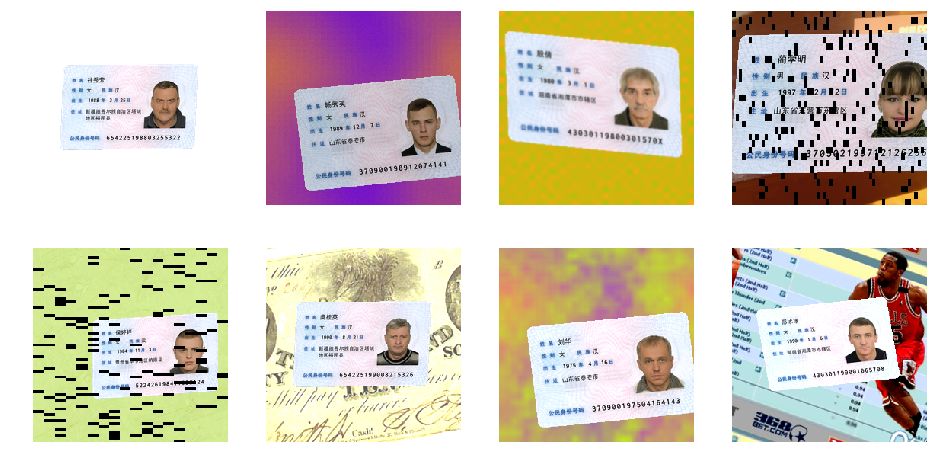

In [10]:
rows = 2
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(4*cols,4*rows))
for i in range(rows):
    for j in range(cols):
        axes[i, j].set_axis_off()
        axes[i, j].imshow(train_x[i * cols + j]);

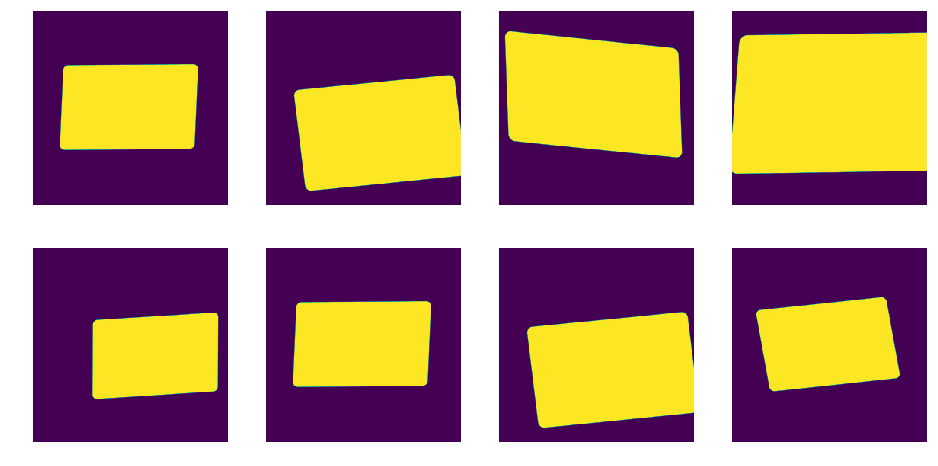

In [11]:
rows = 2
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(4*cols,4*rows))
for i in range(rows):
    for j in range(cols):
        axes[i, j].set_axis_off()
        axes[i, j].imshow(train_y[i * cols + j].reshape((256, 256)));

In [12]:
# acc = []
# val_acc = []
# for _ in range (10):
#     history = model.fit(train_x, train_y,
#                         batch_size=32,
#                         epochs=1,
#                         verbose=1,
#                         validation_split=0.1
#                        )    
#     acc_ = history.history['my_iou_metric'][0]
#     val_acc_ = history.history['val_my_iou_metric'][0]
#     acc.append(acc_)
#     val_acc.append(val_acc_)
#     if acc_ > 0.995:
#         break

In [13]:
# df = pd.DataFrame({'x': list(range(len(acc))), 'y': acc})
# sns.lmplot(x="x", y="y", data=df, order=2);

In [14]:
# df = pd.DataFrame({'x': list(range(len(val_acc))), 'y': val_acc})
# sns.lmplot(x="x", y="y", data=df, order=2);

In [15]:
# model.save_weights(model_weights_path)